In [14]:
# This enables auto-reloading of modules
%load_ext autoreload
%autoreload 2

# Import the model
from iris.src.chat_model.model import model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# Define conversation for testing
conversation = {
    "messages": [
        {"role": "system", "content": "You are a helpful assistant specialized in accounting."},
        {"role": "user", "content": "What is the definition of a business combination under IFRS, search internal CAPM only"}
    ]
}

# You can modify the conversation above to test different scenarios

In [16]:
# Call the model function with our conversation and capture full response without streaming
result = "".join(model(conversation, debug_mode=True))

2025-04-02 14:13:29,401 - root - INFO - Logging system initialized
2025-04-02 14:13:29,402 - root - INFO - Initializing model setup...
2025-04-02 14:13:29,402 - iris.src.initial_setup.ssl.ssl - INFO - SSL certificate setup skipped in local environment
2025-04-02 14:13:29,403 - iris.src.initial_setup.oauth.oauth - INFO - Using API key authentication from local settings
2025-04-02 14:13:29,403 - iris.src.initial_setup.oauth.oauth - INFO - Using OpenAI API key from settings: sk-proj...
2025-04-02 14:13:29,403 - root - INFO - Processing input conversation...
2025-04-02 14:13:29,404 - iris.src.conversation_setup.conversation - INFO - Processed conversation: 2 messages filtered to 1 messages
2025-04-02 14:13:29,404 - root - INFO - Conversation processed: 1 messages
2025-04-02 14:13:29,404 - root - INFO - Getting routing decision...
2025-04-02 14:13:29,404 - iris.src.agents.agent_router.router - INFO - Getting routing decision using model: gpt-4o-mini-2024-07-18
2025-04-02 14:13:29,413 - iris

In [17]:
# Process and analyze the model response and debug data
import json

# Extract model response and debug data
response_content = result
debug_data = None

if "\n\nDEBUG_DATA:" in result:
    # Split the response to separate content from debug data
    parts = result.split("\n\nDEBUG_DATA:")
    response_content = parts[0]
    debug_json = parts[1]
    debug_data = json.loads(debug_json)

# Print the complete debug process with integrated model response
print("# IRIS MODEL DEBUG OUTPUT\n")

# Function to print a section header
def print_section(title):
    print(f"\n{'='*80}\n{title}\n{'='*80}\n")

# Initialize variables to track process flow
current_step = "initialization"
has_printed_response = False

# Process each decision in sequence
if debug_data and "decisions" in debug_data:
    # INITIALIZATION
    print_section("INITIALIZATION")
    print("Starting model process...\n")
    
    # ROUTING DECISION
    router_decisions = [d for d in debug_data["decisions"] if d["stage"] == "router"]
    if router_decisions:
        print_section("ROUTING DECISION")
        decision = router_decisions[0]["decision"]
        print(f"Model decided to use: {decision['function_name']}\n")
    
    # CLARIFICATION
    clarifier_decisions = [d for d in debug_data["decisions"] if d["stage"] == "clarifier"]
    if clarifier_decisions:
        print_section("CLARIFICATION")
        decision = clarifier_decisions[0]["decision"]
        print(f"Research Statement: {decision['output']}\n")
        print(f"Is continuation: {decision['is_continuation']}\n")
    
    # PLANNING
    planner_decisions = [d for d in debug_data["decisions"] if d["stage"] == "planner"]
    if planner_decisions:
        print_section("RESEARCH PLANNING")
        queries = planner_decisions[0]["decision"]["queries"]
        print(f"Created research plan with {len(queries)} queries:\n")
        for i, query in enumerate(queries):
            print(f"{i+1}. Database: {query['database']}")
            print(f"   Query: {query['query']}\n")
    
    # DATABASE QUERIES
    db_decisions = [d for d in debug_data["decisions"] if d["stage"] == "database_query"]
    for i, decision in enumerate(db_decisions):
        print_section(f"QUERY {i+1}: {decision['decision']['database'].upper()}")
        db_data = decision["decision"]
        print(f"Query: {db_data['query']}\n")
        
        # Extract the results from the query
        if i < len(planner_decisions[0]["decision"]["queries"]):
            results = planner_decisions[0]["decision"]["queries"][i]["results"]
            print("Results:")
            print(results)
        
        # Show judgment after first query
        if i == 0:
            judge_decisions = [d for d in debug_data["decisions"] if d["stage"] == "judge"]
            if judge_decisions:
                print_section("RESEARCH JUDGMENT")
                decision = judge_decisions[0]["decision"]
                print(f"Action: {decision['action']}\n")
                print(f"Summary: {decision['summary']}\n")
    
    # MODEL RESPONSE
    print_section("FINAL MODEL RESPONSE")
    print(response_content)
    
    # PROCESS COMPLETION
    print_section("PROCESS COMPLETE")
    print(f"Completed at: {debug_data['end_timestamp']}")
    print(f"Total decisions: {len(debug_data['decisions'])}")
else:
    print("No debug data available in the response.")

# IRIS MODEL DEBUG OUTPUT


INITIALIZATION

Starting model process...


ROUTING DECISION

Model decided to use: research_from_database


CLARIFICATION

Research Statement: Research the definition of a business combination under IFRS as outlined in the Central Accounting Policy Manual (CAPM).

Is continuation: False


RESEARCH PLANNING

Created research plan with 2 queries:

1. Database: internal_capm
   Query: definition of business combination under IFRS

2. Database: external_iasb
   Query: business combination definition IFRS 3


QUERY 1: INTERNAL_CAPM

Query: definition of business combination under IFRS

Results:

    CENTRAL ACCOUNTING POLICY MANUAL RESULTS
    
    Query: definition of business combination under IFRS
    
    The following policy guidelines were found:
    
    1. Policy Section PR-23.4: Accounting for Financial Instruments
       - Classification and measurement requirements
       - Recognition criteria for derivatives and embedded derivatives
       - De-reco

In [18]:
# Additional analysis: Display token and cost information
if debug_data:
    from datetime import datetime
    
    # Display token usage and cost information if available
    if "tokens" in debug_data:
        print("Token Usage and Cost Information:")
        print("---------------------------------")
        print(f"Total tokens: {debug_data['tokens']['total']}")
        print(f"  - Prompt tokens: {debug_data['tokens']['prompt']}")
        print(f"  - Completion tokens: {debug_data['tokens']['completion']}")
        # Format cost with fixed decimal notation to avoid scientific notation for small values
        print(f"Total cost: ${debug_data['cost']:.6f}")
        
        # Calculate time taken
        if "start_timestamp" in debug_data and "end_timestamp" in debug_data:
            start_time = datetime.fromisoformat(debug_data["start_timestamp"])
            end_time = datetime.fromisoformat(debug_data["end_timestamp"])
            duration = (end_time - start_time).total_seconds()
            print(f"Total processing time: {duration:.2f} seconds")
        print()
    
    print("Raw debug data structure:")
    print(json.dumps(debug_data, indent=2))

Token Usage and Cost Information:
---------------------------------
Total tokens: 11553
  - Prompt tokens: 11358
  - Completion tokens: 195
Total cost: $0.000017
Total processing time: 15.71 seconds

Raw debug data structure:
{
  "decisions": [
    {
      "stage": "router",
      "decision": {
        "function_name": "research_from_database"
      },
      "timestamp": "2025-04-02T14:13:30.408029",
      "token_usage": {
        "prompt": 2186,
        "completion": 9,
        "total": 2195,
        "cost": 3.297e-06
      }
    },
    {
      "stage": "clarifier",
      "decision": {
        "action": "create_research_statement",
        "output": "Research the definition of a business combination under IFRS as outlined in the Central Accounting Policy Manual (CAPM).",
        "is_continuation": false
      },
      "timestamp": "2025-04-02T14:13:31.633848",
      "token_usage": {
        "prompt": 2733,
        "completion": 41,
        "total": 2774,
        "cost": 4.181500000000

/var/folders/tz/l7dbw7_d5y31b8xxl8x3l_wc0000gn/T/ipykernel_30475/1107779253.py:33: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  timeline_df['Duration'].iloc[-1] = (last_time - timeline_df['Timestamp'].iloc[-1]).total_seconds()
/var/folders/

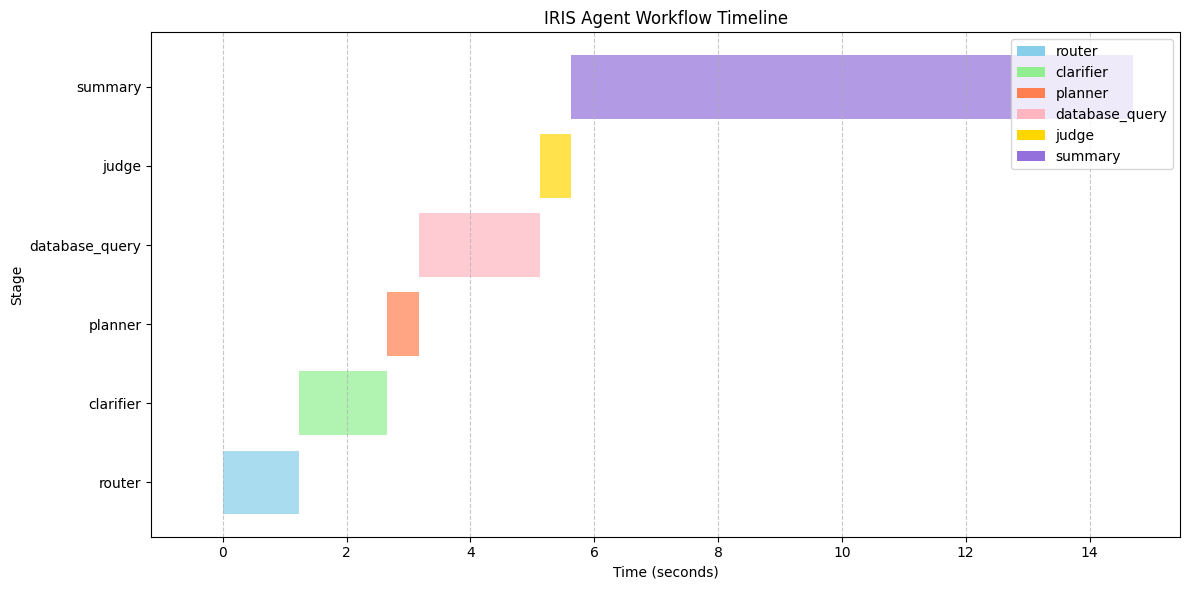

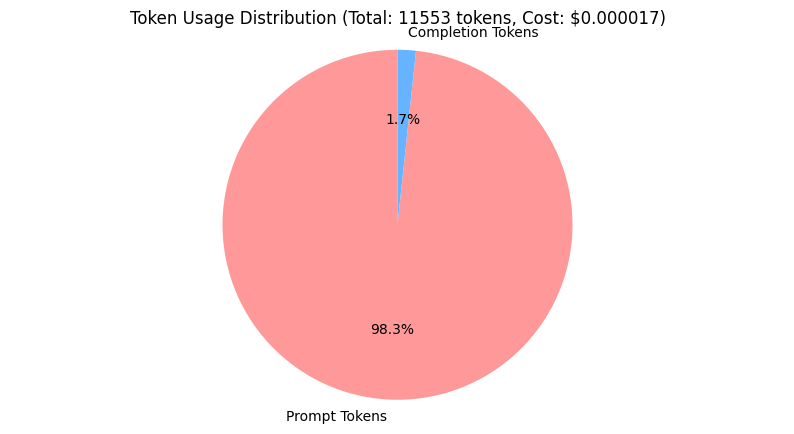

In [19]:
# Optional: Visualize the agent decision workflow timeline
if debug_data and "decisions" in debug_data:
    from datetime import datetime
    import matplotlib.pyplot as plt
    import pandas as pd
    
    # Extract timing information
    decisions = debug_data["decisions"]
    stages = []
    timestamps = []
    
    for decision in decisions:
        stages.append(decision["stage"])
        timestamps.append(datetime.fromisoformat(decision["timestamp"]))
    
    # Create a timeline DataFrame
    timeline_df = pd.DataFrame({
        'Stage': stages,
        'Timestamp': timestamps
    })
    
    # Sort by timestamp
    timeline_df = timeline_df.sort_values('Timestamp')
    
    # Calculate durations
    timeline_df['Duration'] = timeline_df['Timestamp'].diff().shift(-1).dt.total_seconds()
    
    # Handle the duration of the last activity
    if not timeline_df.empty and pd.isna(timeline_df['Duration'].iloc[-1]):
        # If the last row is a summary stage or has no duration, estimate it
        if 'end_timestamp' in debug_data:
            last_time = datetime.fromisoformat(debug_data['end_timestamp'])
            timeline_df['Duration'].iloc[-1] = (last_time - timeline_df['Timestamp'].iloc[-1]).total_seconds()
        else:
            # Default to 0.5 seconds if no end timestamp
            timeline_df['Duration'].iloc[-1] = 0.5
    
    # Create a horizontal bar chart
    plt.figure(figsize=(12, 6))
    
    # Get a color for each stage type
    stage_colors = {
        'router': 'skyblue',
        'clarifier': 'lightgreen',
        'planner': 'coral',
        'database_query': 'lightpink',
        'judge': 'gold',
        'summary': 'mediumpurple'
    }
    
    # Plot each stage
    for i, row in timeline_df.iterrows():
        start_time = (row['Timestamp'] - timeline_df['Timestamp'].min()).total_seconds()
        duration = row['Duration'] if not pd.isna(row['Duration']) else 0.5
        plt.barh(
            row['Stage'], 
            duration, 
            left=start_time, 
            color=stage_colors.get(row['Stage'], 'gray'),
            alpha=0.7
        )
    
    plt.title('IRIS Agent Workflow Timeline')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Stage')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Add a legend
    for stage, color in stage_colors.items():
        if stage in stages:  # Only add to legend if the stage appears in the timeline
            plt.bar(0, 0, color=color, label=stage)
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Add token usage visualization if available
    if "tokens" in debug_data and debug_data["tokens"]["total"] > 0:
        # Create a new figure for token visualization
        plt.figure(figsize=(10, 5))
        
        # Create a pie chart for token distribution
        token_labels = ['Prompt Tokens', 'Completion Tokens']
        token_values = [debug_data["tokens"]["prompt"], debug_data["tokens"]["completion"]]
        
        plt.pie(
            token_values, 
            labels=token_labels,
            autopct='%1.1f%%',
            startangle=90,
            colors=['#ff9999','#66b3ff']
        )
        
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
        # Format cost with fixed decimal notation
        plt.title(f'Token Usage Distribution (Total: {debug_data["tokens"]["total"]} tokens, Cost: ${debug_data["cost"]:.6f})')
        plt.show()

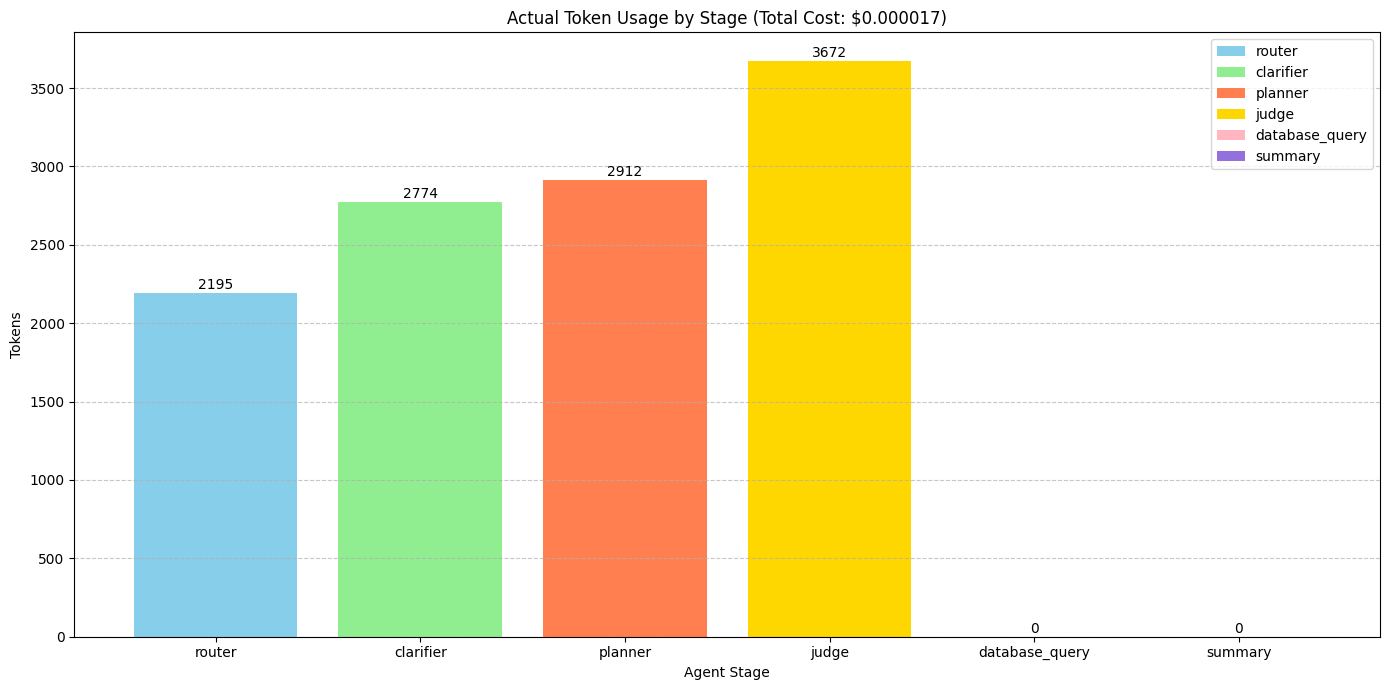

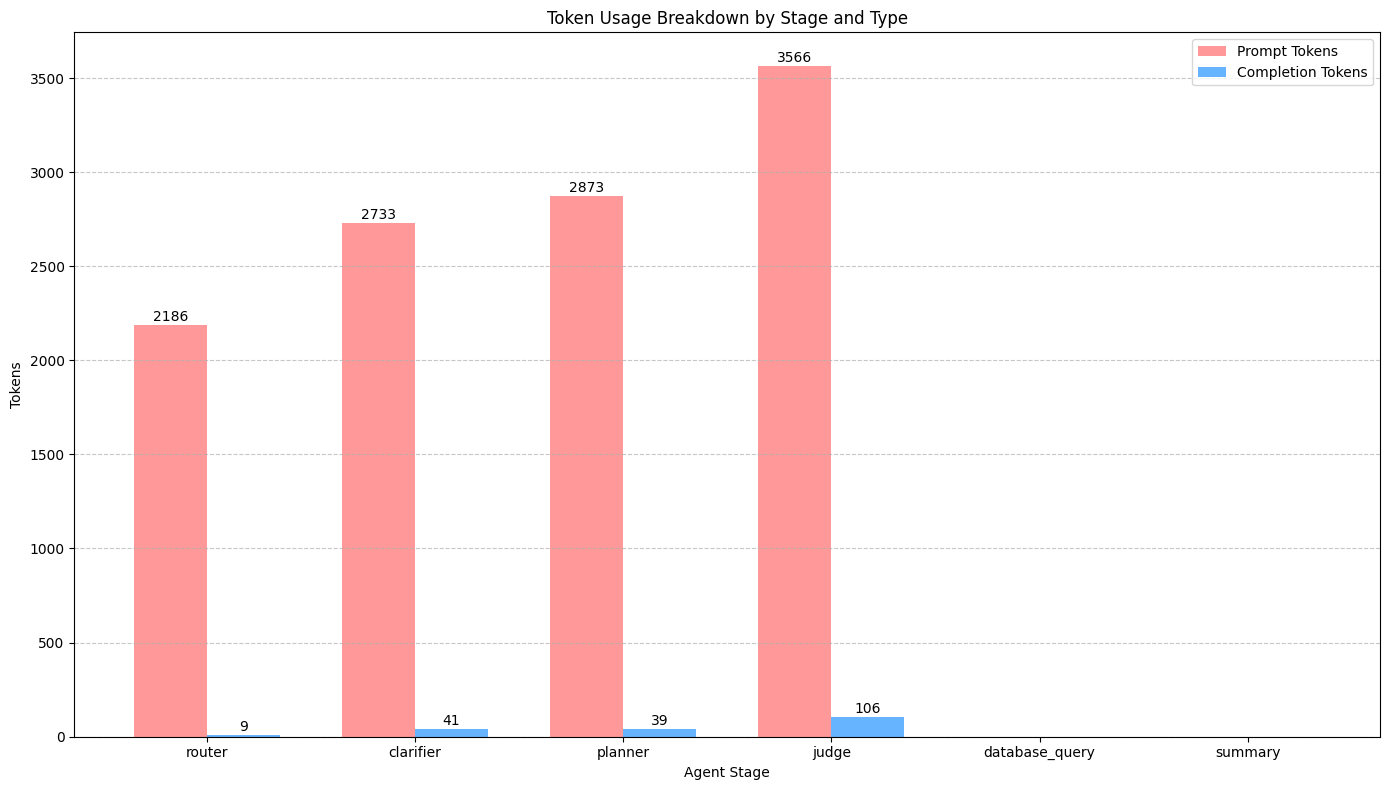

In [20]:
# Add token usage by stage visualization (if token data is available)
if debug_data and "decisions" in debug_data and "tokens" in debug_data and "stages" in debug_data["tokens"]:
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Create a figure for the token usage breakdown by stage
    plt.figure(figsize=(14, 7))
    
    # Define stage order for display
    stage_order = ['router', 'clarifier', 'planner', 'judge', 'database_query', 'summary']
    
    # Get actual token usage per stage from the enhanced data structure
    token_per_stage = {}
    for stage in stage_order:
        if stage in debug_data["tokens"]["stages"]:
            token_per_stage[stage] = debug_data["tokens"]["stages"][stage]["total"]
        else:
            token_per_stage[stage] = 0
    
    # Create bar chart
    stages = list(token_per_stage.keys())
    token_counts = list(token_per_stage.values())
    
    # Define colors for stages
    colors = ['skyblue', 'lightgreen', 'coral', 'gold', 'lightpink', 'mediumpurple']
    
    # Create the bar chart
    bars = plt.bar(stages, token_counts, color=colors)
    
    # Add labels and title
    plt.title(f'Actual Token Usage by Stage (Total Cost: ${debug_data["cost"]:.6f})')
    plt.xlabel('Agent Stage')
    plt.ylabel('Tokens')
    
    # Add token count labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 5,
                 f'{int(height)}',
                 ha='center', va='bottom', rotation=0)
    
    # Add grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add a legend indicating what each color represents
    for i, stage in enumerate(stages):
        plt.bar(0, 0, color=colors[i], label=stage)
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Add a detailed breakdown showing prompt vs completion tokens per stage
    plt.figure(figsize=(14, 8))
    
    # For each stage, show prompt and completion tokens as separate bars
    x = np.arange(len(stages))
    width = 0.35
    
    prompt_tokens = []
    completion_tokens = []
    
    for stage in stages:
        if stage in debug_data["tokens"]["stages"]:
            prompt_tokens.append(debug_data["tokens"]["stages"][stage]["prompt"])
            completion_tokens.append(debug_data["tokens"]["stages"][stage]["completion"])
        else:
            prompt_tokens.append(0)
            completion_tokens.append(0)
    
    # Create grouped bar chart
    prompt_bars = plt.bar(x - width/2, prompt_tokens, width, label='Prompt Tokens', color='#ff9999')
    completion_bars = plt.bar(x + width/2, completion_tokens, width, label='Completion Tokens', color='#66b3ff')
    
    # Add labels and title
    plt.title('Token Usage Breakdown by Stage and Type')
    plt.xlabel('Agent Stage')
    plt.ylabel('Tokens')
    plt.xticks(x, stages)
    
    # Add token count labels on top of bars
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            if height > 0:  # Only add labels for bars with non-zero height
                plt.text(bar.get_x() + bar.get_width()/2., height + 5,
                        f'{int(height)}',
                        ha='center', va='bottom', rotation=0)
    
    add_labels(prompt_bars)
    add_labels(completion_bars)
    
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    # For backward compatibility with existing debug data
    if debug_data and "decisions" in debug_data and "tokens" in debug_data:
        import matplotlib.pyplot as plt
        import numpy as np
        
        # Create a figure for the token usage breakdown by stage
        plt.figure(figsize=(12, 6))
        
        # Define stage order for display
        stage_order = ['router', 'clarifier', 'planner', 'judge', 'database_query']
        
        # Calculate token usage per stage based on the timestamp when tokens were tracked
        # (Note: This is an estimation since per-stage token tracking isn't available)
        token_per_stage = {stage: debug_data["tokens"]["total"] / len(stage_order) for stage in stage_order}
        
        # Create bar chart
        stages = list(token_per_stage.keys())
        token_counts = list(token_per_stage.values())
        
        # Define colors for stages
        colors = ['skyblue', 'lightgreen', 'coral', 'gold', 'lightpink']
        
        # Create the bar chart
        bars = plt.bar(stages, token_counts, color=colors)
        
        # Add labels and title
        plt.title(f'Estimated Token Usage by Stage (Total Cost: ${debug_data["cost"]:.6f})')
        plt.xlabel('Agent Stage')
        plt.ylabel('Tokens')
        
        # Add token count labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 5,
                    f'{int(height)}',
                    ha='center', va='bottom', rotation=0)
        
        # Add grid for better readability
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.show()